# Visualization

Haiku supports two ways to visualize your program. To use these you need to install two additional dependencies:

In [1]:
!pip install dm-tree graphviz

In [2]:
import jax
import jax.numpy as jnp
import haiku as hk

## Tabulate

Like many neural network libraries, Haiku supports showing a summary of the execution of your program as a table of modules. Haiku's approach is to trace the execution of your program and to produce a table of (interesting) module method calls.

For example, the interesting methods for a 3 layer MLP would be `MLP.__call__` which in turns calls `Linear.__call__` on three inner modules. For each module method we show columns relating to the input/output size of arrays, as well as details of the modules parameters and where it fits in the module hierarchy.

In [3]:
def f(x):
  return hk.nets.MLP([300, 100, 10])(x)

f = hk.transform(f)
x = jnp.ones([8, 28 * 28])

print(hk.experimental.tabulate(f)(x))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


+-------------------------+------------------------------------------+-----------------+------------+------------+---------------+---------------+
| Module                  | Config                                   | Module params   | Input      | Output     |   Param count |   Param bytes |
+=========================+==========================================+=================+============+============+===============+===============+
| mlp (MLP)               | MLP(output_sizes=[300, 100, 10])         |                 | f32[8,784] | f32[8,10]  |       266,610 |       1.07 MB |
+-------------------------+------------------------------------------+-----------------+------------+------------+---------------+---------------+
| mlp/~/linear_0 (Linear) | Linear(output_size=300, name='linear_0') | w: f32[784,300] | f32[8,784] | f32[8,300] |       235,500 |     942.00 KB |
|  └ mlp (MLP)            |                                          | b: f32[300]     |            |            |    

We also offer access to the raw data used to build this table if you want to create your own summary:

In [4]:
for method_invocation in hk.experimental.eval_summary(f)(x):
  print(method_invocation)

MethodInvocation(module_details=ModuleDetails(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', params={'mlp/~/linear_0/b': f32[300], 'mlp/~/linear_0/w': f32[784,300], 'mlp/~/linear_1/b': f32[100], 'mlp/~/linear_1/w': f32[300,100], 'mlp/~/linear_2/b': f32[10], 'mlp/~/linear_2/w': f32[100,10]}, state={}), args_spec=(f32[8,784],), kwargs_spec={}, output_spec=f32[8,10], context=MethodContext(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', orig_method=functools.partial(<function MLP.__call__ at 0x7f173d83f600>, MLP(output_sizes=[300, 100, 10])), orig_class=<class 'haiku._src.nets.mlp.MLP'>), call_stack=(ModuleDetails(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', params={'mlp/~/linear_0/b': f32[300], 'mlp/~/linear_0/w': f32[784,300], 'mlp/~/linear_1/b': f32[100], 'mlp/~/linear_1/w': f32[300,100], 'mlp/~/linear_2/b': f32[10], 'mlp/~/linear_2/w': f32[100,10]}, state={}),))
MethodInvocation(module_details=ModuleDetails(module=Linear(output_siz

## Graphviz (aka. `to_dot`)

Haiku supports rendering your program as a graphviz graph. We show all of the JAX primitives involved in a given computation clustered by Haiku module.

Lets start by visualizing a simple program not using Haiku modules:

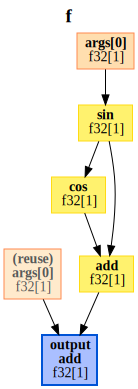

In [5]:
def f(a):
  b = jnp.sin(a)
  c = jnp.cos(b)
  d = b + c
  e = a + d
  return e

x = jnp.ones([1])
dot = hk.to_dot(f)(x)

import graphviz
graphviz.Source(dot)

The visualization above shows our program as a simple dataflow graph of our single input highligted in orange (`args[0]`) being passed through some operations and producing a result (highlighted in blue). Primitive operations (e.g. `sin`, `cos` and `add`) are highlighted in yellow.

Actual Haiku programs are often far more complex, involving many modules and many more primitive operations. For these programs it is often useful to visualize the program on a module by module basis.

`to_dot` offers this by clustering operations by their module. Again it is probably simplest to see an example:

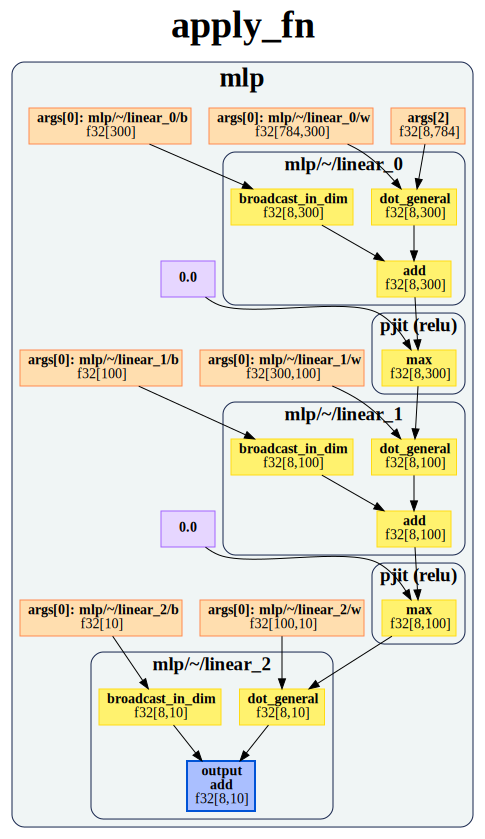

In [6]:
def f(x):
  return hk.nets.MLP([300, 100, 10])(x)

f = hk.transform(f)

rng = jax.random.PRNGKey(42)
x = jnp.ones([8, 28 * 28])
params = f.init(rng, x)

dot = hk.to_dot(f.apply)(params, None, x)
graphviz.Source(dot)